<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#Static-Hamiltonian" data-toc-modified-id="Static-Hamiltonian-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Static Hamiltonian</a></span></li><li><span><a href="#Check-the-pulse-here" data-toc-modified-id="Check-the-pulse-here-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Check the pulse here</a></span></li><li><span><a href="#Driving-term" data-toc-modified-id="Driving-term-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Driving term</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Tomography" data-toc-modified-id="Tomography-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Tomography</a></span></li><li><span><a href="#Optimizer" data-toc-modified-id="Optimizer-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Optimizer</a></span><ul class="toc-item"><li><span><a href="#Use-DRAG-to-optimize-further" data-toc-modified-id="Use-DRAG-to-optimize-further-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Use DRAG to optimize further</a></span></li></ul></li><li><span><a href="#Sweep-parameters" data-toc-modified-id="Sweep-parameters-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Sweep parameters</a></span><ul class="toc-item"><li><span><a href="#Sweep-gate-time" data-toc-modified-id="Sweep-gate-time-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Sweep gate time</a></span></li><li><span><a href="#Sweep-detuning" data-toc-modified-id="Sweep-detuning-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Sweep detuning</a></span><ul class="toc-item"><li><span><a href="#Optimize-T_rise" data-toc-modified-id="Optimize-T_rise-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>Optimize T_rise</a></span></li></ul></li><li><span><a href="#Sweep-coupling" data-toc-modified-id="Sweep-coupling-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Sweep coupling</a></span></li><li><span><a href="#Sweep-DRAG" data-toc-modified-id="Sweep-DRAG-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Sweep DRAG</a></span></li></ul></li></ul></div>

# Preamble

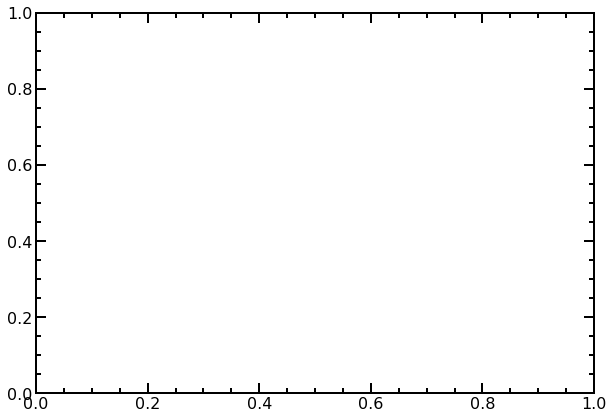

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
import sys
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import Single_small_junction as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as evol_gates
import plotting_settings
import scipy.linalg
from scipy.optimize import minimize
from qutip.qip.operations import*

# Static Hamiltonian

In [152]:
#Define coupled two-level system Hamiltonian
IZ = tensor(qeye(2), sigmaz())
ZI = tensor(sigmaz(), qeye(2))
XI = tensor(sigmax(), qeye(2))
IX = tensor(qeye(2), sigmax())
YI = tensor(sigmay(), qeye(2))
IY = tensor(qeye(2), sigmay())
XX = tensor(sigmax(), sigmax())

def two_q_hamiltonian(w1, w2, J):
    return -0.5*w1*ZI - 0.5*w2*IZ + J*XX

#8q chip Q4 Q5
w1 = 0.4
w2 = 0.5

J = 5e-3 #GHz
H0 = two_q_hamiltonian(w1, w2, J)
eig_energies, eig_states = H0.eigenstates() #System

# Check the pulse here

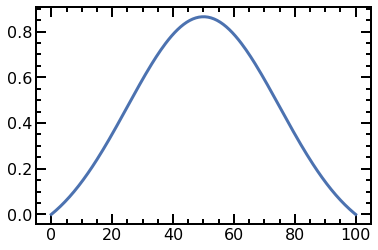

In [123]:
# Gaussian
#Gate parameters
T_start = 0
T_gate = 50
# shape = 'gauss'
# shape = 'square'
shape = 'cosflattop'
T_rise = 25

t = np.linspace(0,T_gate, 2*int(T_gate)+1)
sigma = sigma * T_gate
T_mid = T_start + T_gate / 2
coeff = 1.0
xi_x = coeff * (np.exp(- 0.5 * ((t - T_mid) / sigma) ** 2)
                - np.exp(-0.5 * (0.5 * T_gate / sigma) ** 2))
# xi_x += (beta * coeff * (-1 / sigma ** 2 + ((t - T_mid) / sigma ** 2) ** 2)
#          * np.exp(- 0.5 * ((t - T_mid) / sigma) ** 2))
# xi_y = (alpha * coeff * (- (t - T_mid) / sigma ** 2)
#         * np.exp(- 0.5 * ((t - T_mid) / sigma) ** 2))

plt.plot(t,xi_x)


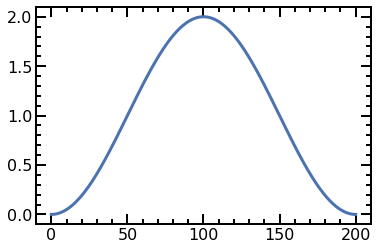

In [4]:
# Cosine
two_pi_t1 = 2 * np.pi * t
two_pi_t2 = 2 * np.pi * (t - T_start)
xi_x =  (1 - np.cos(two_pi_t2 / T_gate))
plt.plot (t, xi_x)

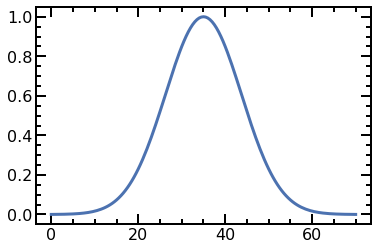

In [5]:
# Gaussian flat top

#Gate parameters
T_start = 0
T_gate = 70
shape = 'gauss'
# shape = 'square'
shape = 'gaussflattop'
sigma = 0.25
T_rise = 35

sigma = sigma * T_rise
T_left = T_start + T_rise
T_right = T_start + T_gate - T_rise

t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
xi_x = np.zeros_like(t_points)

# Without shift and normalization.
for idx, t in enumerate(t_points):
    if t < T_left:
        xi_x[idx] = np.exp(- 0.5 * ((t - T_left) / sigma) ** 2)
    elif t > T_right:
        xi_x[idx] = np.exp(- 0.5 * ((t - T_right) / sigma) ** 2)
    else:
        xi_x[idx] = 1
# Shift to ensure that we start and end at zero.
# xi_x -= np.exp(-0.5 * (T_rise / sigma) ** 2)
#Normalization
# integral_value = (np.sqrt(2 * np.pi) * sigma
#                               * scipy.special.erf(
#                         T_rise / (np.sqrt(2) * sigma))
#                               + T_gate - 2 * T_rise
#                               - T_gate * np.exp(-0.5 * (T_rise / sigma) ** 2))
# xi_x *= 2 * np.pi / integral_value
plt.plot (t_points, xi_x)


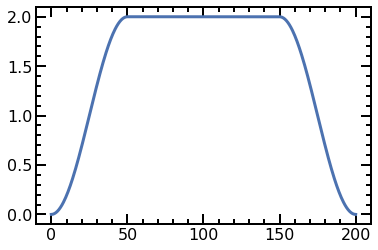

In [6]:
# Cosine flat top

#Gate parameters
T_start = 0
T_gate = 200
sigma = 0.25
T_rise = 50

T_left = T_start + T_rise
T_right = T_start + T_gate - T_rise

t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
xi_x = np.zeros_like(t_points)
alpha = 0
xi_x = np.zeros_like(t_points)
xi_y = np.zeros_like(t_points)
# Without shift and normalization.
for idx, t in enumerate(t_points):
    if t < T_left:
        xi_x[idx] = 1+np.cos(2*np.pi*(t - T_left) / T_rise/2)
        xi_y[idx] = alpha * np.sin(2*np.pi*(t - T_left) / T_rise/2)
    elif t > T_right:
        xi_x[idx] = 1+np.cos(2*np.pi*(t - T_right) / T_rise/2)
        xi_y[idx] = -alpha * np.sin(2*np.pi*(t - T_right) / T_rise/2)
    else:
        xi_x[idx] = 2
        xi_y[idx] = 0
plt.plot (t_points, xi_x)

# Driving term

In [190]:
drive_freq = eig_energies[2]-eig_energies[0] #Second qubit frequency

coupl_const = 200 #Rabi freq in MHz
coupl_const = coupl_const*1e-3*2*np.pi
H1 = coupl_const*(XI) #Driving first qubit only

#Gate parameters
T_start = 0
T_gate = 50
# shape = 'gauss'
# shape = 'square'
# shape = 'gaussflattop'
shape = 'cosflattop'
sigma = 0.25
T_rise = 25
drag = False
drag_coeff = 0.3
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)

#Using propagator
H_dum = tensor(qeye(2), qeye(2))*0
U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points = t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

# Analysis

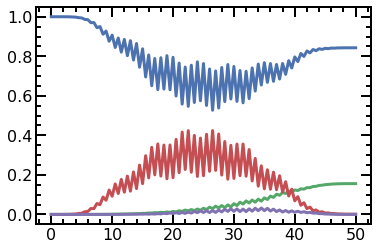

In [191]:
state_00 = eig_states[0]
state_01 = eig_states[2]
state_10 = eig_states[1]
state_11 = eig_states[3]
sup_state0 = (state_00 + state_01)/np.sqrt(2)
sup_state1 = (state_10 + state_11)/np.sqrt(2)

trans_prob_00_00 = expect(state_00 * state_00.dag(),U_t*state_00)
trans_prob_00_01 = expect(state_01 * state_01.dag(),U_t*state_00)
trans_prob_00_10 = expect(state_10 * state_10.dag(),U_t*state_00)
trans_prob_00_11 = expect(state_11 * state_11.dag(),U_t*state_00)
# U_rw = U_nothing*U_t
sx0 = expect(IX,U_t*state_00)
sy0 = expect(IY,U_t*state_00)
sz0 = expect(IZ,U_t*state_00)
sx1 = expect(IX,U_t*state_10)
sy1 = expect(IY,U_t*state_10)
sz1 = expect(IZ,U_t*state_10)

# sx0 = expect(IX,U_rw*state_00)
# sy0 = expect(IY,U_rw*state_00)
# sz0 = expect(IZ,U_rw*state_00)
# sx1 = expect(IX,U_rw*state_10)
# sy1 = expect(IY,U_rw*state_10)
# sz1 = expect(IZ,U_rw*state_10)

plt.plot(t_points, trans_prob_00_00, label = '00')
plt.plot(t_points, trans_prob_00_01, label = '01')
plt.plot(t_points, trans_prob_00_10, label = '10')
plt.plot(t_points, trans_prob_00_11, label = '11')
# plt.plot(t_points, np.cos(2*np.pi*coupl_const*1e-2 * 1e9 *t_points*1e-9))
# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize = [10,12])
# ax1.plot(t_points, sx0, label = 'C0')
# ax1.plot(t_points, sx1, label = 'C1')
# ax2.plot(t_points, sy0, label = 'C0')
# ax2.plot(t_points, sy1, label = 'C1')
# ax3.plot(t_points, sz0, label = 'C0')
# ax3.plot(t_points, sz1, label = 'C1')

# ax1.legend()
# ax2.legend()
# ax3.legend()

# plt.xlabel('Time (ns)')
# plt.ylabel(r'$P$')

# b = Bloch()
# b.add_points([sx0, sy0, sz0], meth='l')
# b.make_sphere()

48.5
97
0.7268565877304223


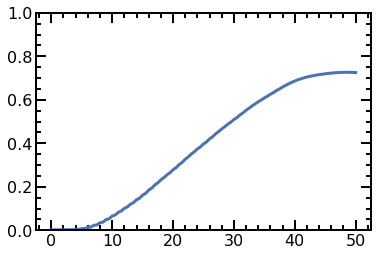

In [192]:
R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
plt.plot(t_points, R, label = '0')
plt.ylim([0,1])
print (t_points[np.argmax(R)])
print(np.argmax(R))
print (np.max(R))

In [156]:
u00 = U_t[-1].matrix_element(state_00, state_00)
u01 = U_t[-1].matrix_element(state_01, state_01)
u10 = U_t[-1].matrix_element(state_10, state_10)
u11 = U_t[-1].matrix_element(state_11, state_11)
phase1 = np.angle(u01/u00)
phase2 = np.angle(u10/u00)
# print(phase1)
# print(phase2)

single_qu_z = 0
single_qu_z = single_qu_z + state_00*state_00.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
U = single_qu_z*U_t[-1]

u00 = U.matrix_element(state_00, state_00)
u01 = U.matrix_element(state_01, state_01)
u10 = U.matrix_element(state_10, state_10)
u11 = U.matrix_element(state_11, state_11)
phase1 = np.angle(u00*u01/(u10*u11))
phase2 = np.angle(u00*u10/(u01*u11))
print(phase1)
print(phase2)

-4.2369184199384446e-16
1.6947673679753784e-16


In [128]:
rzx_m = np.diag(np.ones(4, dtype = complex))
rzx_m[0,2] = -1j
rzx_m[1,3] = 1j
rzx_m[2,0] = -1j
rzx_m[3,1] = 1j
rzx_m = rzx_m/ np.sqrt(2)
rzx_m = Qobj(rzx_m)
rzx_m.dims = [[2,2],[2,2]]
print (rzx_m*np.sqrt(2))
print (tensor(qeye(2), rx(-np.pi/2)))

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+1.j]
 [0.-1.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+1.j 0.+0.j 1.+0.j]]
Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0.70710678+0.j         0.        +0.70710678j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.70710678j 0.70710678+0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.70710678+0.j
  0.        +0.70710678j]
 [0.        +0.j         0.        +0.j         0.        +0.70710678j
  0.70710678+0.j        ]]


# Tomography

<ipython-input-66-3ed0005e19dd>:30: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_ideal_2q = np.linalg.lstsq(p_in, p_out)[0]


(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd7fd5031c0>)

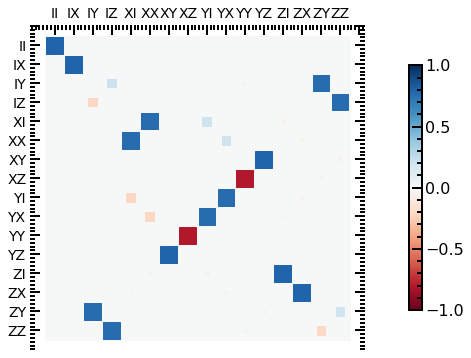

In [66]:
prep_generator = [qeye(2), ry(np.pi/2.0), rx(np.pi/2.0), sigmax()]
prep_rotations = []
for q1gate in prep_generator:
    for q2gate in prep_generator:
        gate = (tensor(q1gate, q2gate))
        prep_rotations.append(gate)

meas_generator = [qeye(2), sigmax(), sigmay(), sigmaz()]
meas_rotations = []
for q1gate in meas_generator:
    for q2gate in meas_generator:
        gate = (tensor(q1gate, q2gate))
        meas_rotations.append(gate)
        
p_in = np.zeros((16,16)) 
p_out = np.zeros((16,16)) 

gnd_state = tensor(basis(2,0), basis(2,0))
# gate_op = tensor(qeye(2), rx(np.pi/2))
# gate_op = tensor(rx(np.pi/2), qeye(2))
# gate_op = cnot()
# gate_op = rzx_m
U_Z2I = tensor(rz(-np.pi/2), qeye(2))
U_IX2 = tensor(qeye(2), rx(-np.pi/2))
gate_op = U_Z2I * U * U_IX2
for i, rot_i in enumerate(prep_rotations):
    for j, rot_j in enumerate(meas_rotations):
        p_in[i,j] = expect(rot_j, rot_i*gnd_state)
        p_out[i,j] = expect(rot_j, gate_op*(rot_i*gnd_state))        
ptm_ideal_2q = np.linalg.lstsq(p_in, p_out)[0]

str_primitive = ["I","X","Y","Z"]
op_label = []
for prim1 in str_primitive:
    for prim2 in str_primitive:
        op_label.append(prim1+prim2)
# print (op_label)
qutip.hinton(ptm_ideal_2q, xlabels = op_label, ylabels = op_label)


In [67]:
U_ideal = cnot()
U_real = gate_op

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
print (fidel)

0.9852314376234623


# Optimizer

In [134]:
U_ideal = cnot()
T_start = 0
T_gate = 100
T_rise = 50
def infidelity(x):
    coupl = x[0]
    coupl_const = coupl*1e-3*2*np.pi
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]

    U_Z2I = tensor(rz(-np.pi/2), qeye(2))
    U_IX2 = tensor(qeye(2), rx(-np.pi/2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return 1-fidel
    
x0 = [800] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
fidelity = 1.0-infidelity(xopt.x)

In [135]:
print (fidelity)
print (xopt.x)

0.998869546440788
[731.27830162]


## Use DRAG to optimize further

In [141]:
U_ideal = cnot()
T_start = 0
T_gate = 100
T_rise = 50
drag = True

def infidelity(x):
    coupl = x[0]
    drag_coeff = x[1]
    delta_omega = x[2]
    coupl_const = coupl*1e-3*2*np.pi
    drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
    H1 = coupl_const*(XI)
    U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

    u00 = U_t[-1].matrix_element(state_00, state_00)
    u01 = U_t[-1].matrix_element(state_01, state_01)
    u10 = U_t[-1].matrix_element(state_10, state_10)
    u11 = U_t[-1].matrix_element(state_11, state_11)
    phase1 = np.angle(u01/u00)
    phase2 = np.angle(u10/u00)

    single_qu_z = 0
    single_qu_z = single_qu_z + state_00*state_00.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
    single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
    single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
    U = single_qu_z*U_t[-1]

    U_Z2I = tensor(rz(-np.pi/2), qeye(2))
    U_IX2 = tensor(qeye(2), rx(-np.pi/2))
    U_real = U_Z2I * U * U_IX2
    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
    return 1-fidel
    
x0 = [750,0,0] #guess
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-7)
fidelity = 1.0-infidelity(xopt.x)

In [142]:
print (fidelity)
print (xopt.x)

0.9995429854337352
[ 6.75126101e+02 -2.87464571e-01  1.10478598e-03]


# Sweep parameters

## Sweep gate time

In [197]:
from scipy.optimize import minimize

#Gate parameters
T_start = 0
T_gate_array = np.linspace(50,350,6)
R_array = np.zeros_like(T_gate_array)
fidelity = np.zeros_like(T_gate_array)
coupl_const_array = np.zeros_like(T_gate_array)

shape = 'cosflattop'
drag = True
U_ideal = cnot()

#for loop here!!!!!
for idx, T_gate in enumerate (T_gate_array):
    t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
    T_rise = T_gate/2
    def infidelity(x):
        coupl = x[0]
        drag_coeff = x[1]
        delta_omega = x[2]
        drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
        coupl_const = coupl*1e-3*2*np.pi
        H1 = coupl_const*(XI)
        U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
           
        u00 = U_t[-1].matrix_element(state_00, state_00)
        u01 = U_t[-1].matrix_element(state_01, state_01)
        u10 = U_t[-1].matrix_element(state_10, state_10)
        u11 = U_t[-1].matrix_element(state_11, state_11)
        phase1 = np.angle(u01/u00)
        phase2 = np.angle(u10/u00)

        single_qu_z = 0
        single_qu_z = single_qu_z + state_00*state_00.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
        single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
        U = single_qu_z*U_t[-1]
        
        U_Z2I = tensor(rz(-np.pi/2), qeye(2))
        U_IX2 = tensor(qeye(2), rx(-np.pi/2))
        U_real = U_Z2I * U * U_IX2
        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
        return 1-fidel
    coupl_guess = 50*(200/T_gate)
    x0 = [coupl_guess,-0.2,0] #guess
    xopt = minimize(infidelity, x0, method ='Powell', tol = None)
    coupl_const_array[idx] = xopt.x[0]
    fidelity[idx] = 1.0-infidelity(xopt.x)

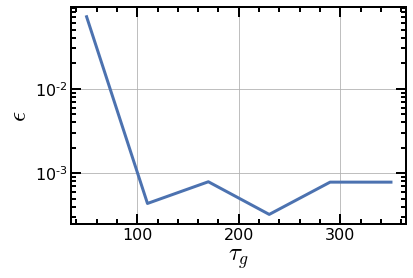

In [198]:
plt.plot(T_gate_array, 1-fidelity)
plt.yscale('log')
plt.xlabel(r'$\tau_g$')
plt.ylabel(r'$\epsilon$')
plt.grid()


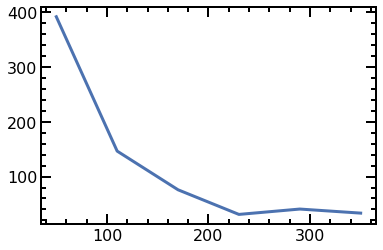

In [199]:
plt.plot(T_gate_array, coupl_const_array)

## Sweep detuning

In [143]:
#Gate parameters to sweep
detuning_array = np.linspace(50,300,6)*1e-3
T_gate_array = np.linspace(100,300,3)
infidelity_array = np.zeros((len(detuning_array),len(T_gate_array)))
coupl_const_array = np.zeros((len(detuning_array),len(T_gate_array)))
U_ideal = cnot()
T_start = 0

for t_idx, T_gate in enumerate(T_gate_array):
    t_points = np.linspace(0, T_gate, 2*int(T_gate)+1)
    T_rise = T_gate/2
    
    for d_idx, detuning in enumerate (detuning_array):
        w2 = w1 + detuning
        H0 = two_q_hamiltonian(w1, w2, J)
        eig_energies, eig_states = H0.eigenstates()
        drive_freq = eig_energies[2] - eig_energies[0]
        def infidelity(x):
            coupl = x[0]
            drag_coeff = x[1]
            delta_omega = x[2]
            drive_freq = eig_energies[2]-eig_energies[0] + delta_omega
            coupl_const = coupl*1e-3*2*np.pi
            H1 = coupl_const*(XI)
            U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)

            u00 = U_t[-1].matrix_element(state_00, state_00)
            u01 = U_t[-1].matrix_element(state_01, state_01)
            u10 = U_t[-1].matrix_element(state_10, state_10)
            u11 = U_t[-1].matrix_element(state_11, state_11)
            phase1 = np.angle(u01/u00)
            phase2 = np.angle(u10/u00)

            single_qu_z = 0
            single_qu_z = single_qu_z + state_00*state_00.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
            single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
            single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
            U = single_qu_z*U_t[-1]

            U_Z2I = tensor(rz(-np.pi/2), qeye(2))
            U_IX2 = tensor(qeye(2), rx(-np.pi/2))
            U_real = U_Z2I * U * U_IX2
            op1 = U_real.dag() * U_real
            op2 = U_real * U_ideal.dag()
            fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
            return 1-fidel
        coupl_guess = detuning*1e3*2 /(T_gate/100)
        x0 = [coupl_guess,0,0] #guess
        xopt = minimize(infidelity, x0, method ='Powell', tol = None)
        coupl_const_array[d_idx, t_idx] = xopt.x[0]
        infidelity_array [d_idx, t_idx] = infidelity(xopt.x)

In [144]:
#Save data here
path = '..\CR_sweep_20210921 .txt'
to_save = infidelity_array
np.savetxt(to_save,path)

ValueError: fname must be a string or file handle

Text(0, 0.5, '$\\epsilon$')

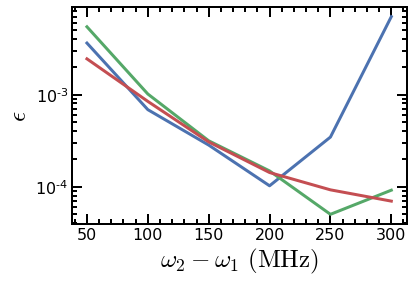

In [145]:
for idx, T_gate in enumerate(T_gate_array):
    plt.plot(detuning_array*1e3, infidelity_array[:,idx])
plt.yscale("log")
plt.xlabel(r"$\omega_2 - \omega_1~\mathrm{(MHz)}$")
plt.ylabel(r'$\epsilon$')

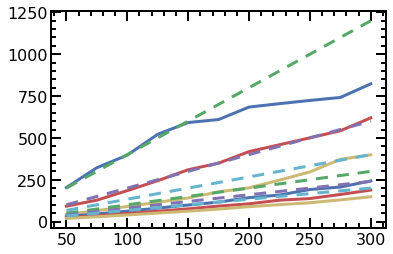

In [121]:
for idx, T_gate in enumerate(T_gate_array):
    plt.plot(detuning_array*1e3, coupl_const_array[:,idx])
    plt.plot(detuning_array*1e3, detuning_array*1e3*2 /(T_gate/100), '--')
# plt.ylim([0,200])

### Optimize T_rise

In [37]:
#Gate parameters
detuning_array = np.linspace(50,300,11)*1e-3

T_start = 0
T_gate = 100
# T_rise = 40
R_array = np.zeros_like(detuning_array)
infidelity_array = np.zeros_like(detuning_array)
coupl_const_array = np.zeros_like(detuning_array)

shape = 'cosflattop'
# shape = 'square'
drag = False
U_ideal = cnot()

t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
#for loop here!!!!!
for idx, detuning in enumerate (detuning_array):
    w2 = w1 + detuning
    H0 = two_q_hamiltonian(w1, w2, J)
    eig_energies, eig_states = H0.eigenstates()
    drive_freq = eig_energies[2] - eig_energies[0]
    def infidelity(x):
        coupl = x[0]
        T_rise = x[1]
        coupl_const = coupl*1e-3*2*np.pi
        H1 = coupl_const*(XI)
        U_t = evol_gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
           
        u00 = U_t[-1].matrix_element(state_00, state_00)
        u01 = U_t[-1].matrix_element(state_01, state_01)
        u10 = U_t[-1].matrix_element(state_10, state_10)
        u11 = U_t[-1].matrix_element(state_11, state_11)
        phase1 = np.angle(u01/u00)
        phase2 = np.angle(u10/u00)

        single_qu_z = 0
        single_qu_z = single_qu_z + state_00*state_00.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
        single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
        U = single_qu_z*U_t[-1]
        
        U_Z2I = tensor(rz(-np.pi/2), qeye(2))
        U_IX2 = tensor(qeye(2), rx(-np.pi/2))
        U_real = U_Z2I * U * U_IX2
        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
        return 1-fidel
    coupl_guess = detuning*1e3 - 20
    x0 = [coupl_guess, 30] #guess
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-9)
    coupl_const_array[idx] = xopt.x[0]
    infidelity_array [idx] = infidelity(xopt.x)

Text(0, 0.5, '$\\epsilon$')

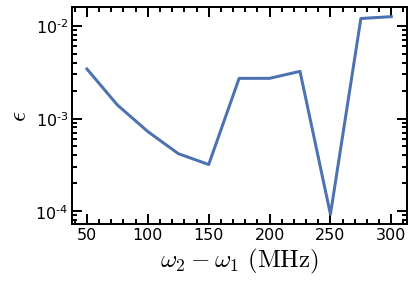

In [38]:
plt.plot(detuning_array*1e3, infidelity_array)
plt.yscale("log")
plt.xlabel(r"$\omega_2 - \omega_1~\mathrm{(MHz)}$")
plt.ylabel(r'$\epsilon$')

## Sweep coupling

In [87]:
coupl_const_array = np.linspace(100,500,21)
R_max = np.zeros_like(coupl_const_array)
T_best = np.zeros_like(coupl_const_array)

T_gate = 400
T_rise = 20
t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
for idx, coupl in enumerate(coupl_const_array):
    coupl_const = coupl*1e-3*2*np.pi
    H1 = coupl_const*(XI) #Driving first qubit only
    U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
    sx0 = expect(IX,U_t*state_00)
    sy0 = expect(IY,U_t*state_00)
    sz0 = expect(IZ,U_t*state_00)
    sx1 = expect(IX,U_t*state_10)
    sy1 = expect(IY,U_t*state_10)
    sz1 = expect(IZ,U_t*state_10)
    R = 0.5*np.sqrt((sx0-sx1)**2 + (sy0-sy1)**2+(sz0-sz1)**2)
    R_max[idx] = R[-1]
    T_best[idx] = t_points[np.argmax(R)]

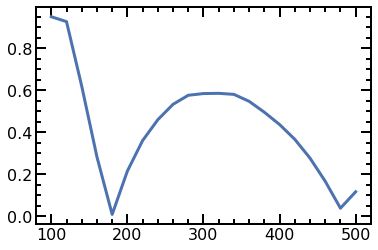

In [88]:
plt.plot(coupl_const_array, R_max)

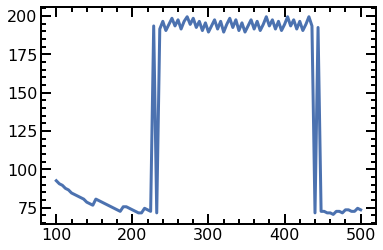

In [84]:
plt.plot(coupl_const_array, T_best)

## Sweep DRAG

In [ ]:
#Gate parameters
T_start = 0
T_gate_array = np.linspace(50,200,151)
R_array = np.zeros_like(T_gate_array)
fidelity = np.zeros_like(T_gate_array)
coupl_const_array = np.zeros_like(T_gate_array)

shape = 'cosflattop'
# shape = 'square'
sigma = 0.25
T_gate = 100
T_rise = 50
drag = False
drag_coeff = 0.1
U_ideal = cnot()

#for loop here!!!!!
for idx, T_gate in enumerate (T_gate_array):
    t_points = np.linspace(0,T_gate, 2*int(T_gate)+1)
    
    def infidelity(x):
        coupl = x[0]
        coupl_const = coupl*1e-3*2*np.pi
        H1 = coupl_const*(XI)
        U_t = gates.evolution_operator_microwave_nonorm(H0,H1, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
            T_gate=T_gate, shape=shape, sigma=sigma, T_rise = T_rise, omega_d=drive_freq)
           
        u00 = U_t[-1].matrix_element(state_00, state_00)
        u01 = U_t[-1].matrix_element(state_01, state_01)
        u10 = U_t[-1].matrix_element(state_10, state_10)
        u11 = U_t[-1].matrix_element(state_11, state_11)
        phase1 = np.angle(u01/u00)
        phase2 = np.angle(u10/u00)

        single_qu_z = 0
        single_qu_z = single_qu_z + state_00*state_00.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase1)*state_01*state_01.dag()
        single_qu_z = single_qu_z + np.exp(-1j*phase2)*state_10*state_10.dag()
        single_qu_z = single_qu_z + np.exp(-1j*(phase1 + phase2))*state_11*state_11.dag()
        U = single_qu_z*U_t[-1]
        
        U_Z2I = tensor(rz(-np.pi/2), qeye(2))
        U_IX2 = tensor(qeye(2), rx(-np.pi/2))
        U_real = U_Z2I * U * U_IX2
        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 20.0
        return 1-fidel
    
    x0 = [100] #guess
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
    coupl_const_array[idx] = xopt.x[0]
    fidelity[idx] = 1.0-infidelity(xopt.x)